In [1]:
import os

new_directory = "/home/geon/dev_geon/ml-testbed"  # 변경하고자 하는 새 디렉토리 경로로 대체
os.chdir(new_directory)

In [2]:
import os
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split
current_directory = os.getcwd()
print("현재 작업 디렉토리:", current_directory)

현재 작업 디렉토리: /home/geon/dev_geon/ml-testbed


In [3]:
import torch
from src.models.components.conv_lstm_classifier_no_dropout_outputsize_control import CONV_LSTM_Classifier
# 모델 불러오기




In [4]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from typing import List,Tuple
import librosa
import math
import torch
from torch.utils.data import Dataset, random_split
from scipy.signal import spectrogram, butter, sosfilt
from scipy.stats import kurtosis
from torch.utils.data import Dataset
import scipy
import scipy.signal as signal
def sampling_with_bandpass(data , sf, rf):
    rotational_frequency = rf  # 회전 주파수 30Hz
    frequencies_to_filter = [rotational_frequency * i for i in range(1, 9)]  # 1배, 2배, 3배, 4배 주파수
    frequencies_to_filter.append(120)  # 추가적으로 120Hz 필터링

    # 대역폭 설정 (+/- 10Hz)
    bandwidth = 10

    # 예제 신호 생성: 여러 주파수 성분과 잡음 포함

    # 필터링된 신호를 저장할 딕셔너리
    filtered_signals = []

    # 각 주파수 대역에 대한 필터링
    for f in frequencies_to_filter:
        band = [f - bandwidth, f + bandwidth]
        b, a = signal.butter(4, [band[0]/(sf/2), band[1]/(sf/2)], btype='band')
        analytic_signal = signal.hilbert(signal.filtfilt(b, a, data))
        # Compute the envelope
        envelope = np.abs(analytic_signal)
        filtered_signals.append(envelope)

    return np.stack(filtered_signals, axis=1)

def original_fft(signal,sf):
    _signal = signal
    y = np.abs(np.fft.fft(_signal,axis = 0)/len(signal))        # fft computing and normaliation
    y = y[range(math.trunc(len(signal)/2))]  
    k = np.arange(len(signal))
    f0=k*sf/len(signal)    # double sides frequency range
    f0=f0[range(math.trunc(len(signal)/2))]  
    return f0, y

def is_peak_at_frequency(freq, spectrum,threshold):
    # 실제 구현에선 주파수 스펙트럼에서 해당 주파수의 진폭이 피크를 형성하는지 검사
    return spectrum[int(freq)] > threshold
                
def estimate_rpm(numpy_array, sf=8192, f_min=27.6, f_max=29.1, f_r=1, M=60, c=2):

    f, magnitude_spectrum = original_fft(numpy_array, sf)
    # 속도 후보들과 그에 대한 초기 확률 설정
    candidates = np.arange(f_min, f_max, f_r/M)
    probabilities = np.ones_like(candidates)  # 모든 후보에 동일한 초기 확률 할당
    #print(f"3분위수 :{np.percentile(magnitude_spectrum, 75)}")
    #print(f"중위수 : {np.percentile(magnitude_spectrum, 50)}")
    #print(f"평균 : {np.mean(magnitude_spectrum)}")
    #print(f"최대 : {np.max(magnitude_spectrum)}")
    threshold = np.mean(magnitude_spectrum)*1.5
    # 후보들의 조화 검사 및 확률 업데이트
    for i, fc in enumerate(candidates):
        for k in range(1, M+1):
            harmonic_freq = k * fc
                    
            if not is_peak_at_frequency(harmonic_freq, magnitude_spectrum,threshold):
                probabilities[i] /= c  # 피크가 없으면 확률 감소
                # 최종 추정 속도 결정
    estimated_speed = candidates[np.argmax(probabilities)]


    #print(f'Estimated speed: {estimated_speed} Estimated rpm: {estimated_speed*60}')
    return estimated_speed*60

def engine_order_fft(signal, rpm, sf = 8192, res = 100, ts = 1):
    _signal = signal[:int(sf*ts)]
    pad_length = int(sf*(res * 60/rpm - ts))
    zero_padded_signal = np.concatenate((_signal, np.zeros(pad_length)))
    y = np.abs(np.fft.fft(zero_padded_signal)/len(zero_padded_signal))     
    y = y[range(math.trunc(len(signal)))]     
    return y[:sf]

def min_max_scaling(data, new_min=-1, new_max=1):
    min_val = np.min(data)
    max_val = np.max(data)
    scaled_data = new_min + (data - min_val) * (new_max - new_min) / (max_val - min_val)
    return scaled_data

def standard_scaling(data):
    mean = np.mean(data,axis = 0 )
    std = np.std(data,axis = 0 )
    scaled_data = (data - mean) / (std + 1e-8)
    return scaled_data

class CustomDatasetWithBandpass(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        self.shuffle_dataset()
        
    def shuffle_dataset(self):
        # 데이터와 레이블을 함께 셔플
        indices = np.arange(len(self.data))
        np.random.shuffle(indices)
        self.data = [self.data[i] for i in indices]
        self.targets = [self.targets[i] for i in indices]
        
    def __len__(self):
        return len(self.data)
        

    def __getitem__(self, idx):
        x = torch.Tensor(self.data[idx])
        y = self.targets[idx]
        
        return x, y
    
    def get_targets(self):
        return torch.LongTensor(self.targets)

class Motor_Vibration():
    def __init__(
        self,
        #train_motor_power: List[str] = ["5.5kW"],
        out_motor_power: List[str] = [],
        test_motor_power: List[str] = ["5.5kW"],
        val_motor_power: List[str] = [],
        sampling_frequency_before_upsample: int = 4000,
        sampling_frequency_after_upsample: int = 8192,
        fault_type_dict = {"정상": 0,
              "베어링불량": 1,
              "벨트느슨함": 2,
              "축정렬불량": 3,
              "회전체불평형": 4},
        upsample_method : str = "soxr_vhq", #["soxr_vhq", "soxr_hq","kaiser_fast","kaiser_best","sinc_best","sinc_fastest"]
        train: bool = True,
        csv_num_to_use: int = 10,
        root: str = "/home/mongoose01/mongooseai/data/cms/open_source/AI_hub/기계시설물 고장 예지 센서/Training/vibration"
    ):
        super().__init__()
        #self.train_motor_power = train_motor_power
        self.out_motor_power = out_motor_power
        self.test_motor_power = test_motor_power
        self.val_motor_power = val_motor_power
        self.sampling_frequency_before_upsample = sampling_frequency_before_upsample
        self.sampling_frequency_after_upsample = sampling_frequency_after_upsample
        self.upsample_method = upsample_method
        self.fault_type_dict = fault_type_dict
        self.train = train
        self.csv_num_to_use = csv_num_to_use
        self.root = root
    def envelope_spectrum(self, signal, fs):
        """
        Compute the envelope spectrum of a signal.
        
        Args:
        signal (numpy array): Input signal.
        fs (float): Sampling frequency of the signal.
        
        Returns:
        freqs (numpy array): Frequencies of the envelope spectrum.
        envelope (numpy array): Envelope spectrum of the signal.
        """
        # Compute the analytic signal using Hilbert transform
        analytic_signal = scipy.signal.hilbert(signal)
        # Compute the envelope
        envelope = np.abs(analytic_signal)

        # Compute the FFT of the envelope
        envelope_fft = np.fft.fft(envelope)
        # Compute the corresponding frequencies
        freqs = np.fft.fftfreq(len(envelope), 1 / fs)
        
        # Take only the positive frequencies and their corresponding FFT values

        freqs = freqs[:]
        envelope_fft = np.abs(envelope_fft[:])

        return envelope, envelope_fft
    @staticmethod
    def up_sample(input_wav, origin_sr, resample_sr, upsample_method):
        resample = librosa.resample(y=input_wav, orig_sr=origin_sr, target_sr=resample_sr, res_type=upsample_method)
        return resample

    def calculate_kurtosis_for_windows(self, signal, fs, window_lengths):
        kurtogram_data = {}
        nfft = max(window_lengths)  # Set nfft to the maximum window length for consistent frequency bins
        for window_length in window_lengths:
            f, t, Sxx = spectrogram(signal, fs=fs, window=('tukey', 0.25), nperseg=window_length, nfft=nfft)
            amplitude_envelope = np.abs(Sxx)
            freq_kurtosis = kurtosis(amplitude_envelope, axis=1)
            kurtogram_data[window_length] = freq_kurtosis
        return kurtogram_data

    def custom_filtering(self, signal, sf):
        window_lengths = [2**i for i in range(3, 12)]  # Adjust the range as needed
        # Calculate kurtosis for different window lengths
        kurtogram_data = self.calculate_kurtosis_for_windows(signal, sf, window_lengths)
        nfft = max(window_lengths)
        levels = np.array(sorted(kurtogram_data.keys()))
        kurtosis_data = np.array([kurtogram_data[level] for level in levels])
        max_kurtosis_index = np.argmax(kurtosis_data)
        # Convert the index to 2D form (level_index, frequency_index)
        level_index, frequency_index = np.unravel_index(max_kurtosis_index, kurtosis_data.shape)
        # Retrieve the actual window length and frequency
        max_window_length = levels[level_index]
        # Calculate the spectrogram
        frequencies, times, Sxx = spectrogram(signal, sf, window=('tukey', 0.25), nperseg=max_window_length)
        # Calculate the spectral kurtosis for each frequency band
        spectral_kurt = kurtosis(Sxx, axis=1, fisher=True, bias=False)
        
        max_kurtosis_idx = np.argmax(spectral_kurt)
        # Find the corresponding frequency
        max_kurtosis_freq = frequencies[max_kurtosis_idx]
        while not (max_kurtosis_freq <= 3800 and max_kurtosis_freq >= 150):
            spectral_kurt[max_kurtosis_idx] = -np.inf
            max_kurtosis_idx = np.argmax(spectral_kurt)
            max_kurtosis_freq = frequencies[max_kurtosis_idx]
        band_width = 128
        low_freq = max(0, max_kurtosis_freq - band_width)
        high_freq = min(max_kurtosis_freq + band_width, sf/2)  # Assuming the Nyquist frequency is at least 2000 Hz
        # Design the bandpass filter
        fs = sf  # Sampling frequency
        nyquist = fs / 2
        low = low_freq / nyquist
        high = high_freq / nyquist
        sos = butter(4, [low, high], btype='band', output='sos')
        # Apply the bandpass filter to the signal
        filtered_signal = sosfilt(sos, signal)
        return filtered_signal


    def process_csv(self, csv_path, fault):
        data = np.loadtxt(csv_path, delimiter=',', skiprows=9, usecols=(1,), max_rows=4000)
        data = standard_scaling(data*100)
        data = Motor_Vibration.up_sample(data, self.sampling_frequency_before_upsample, self.sampling_frequency_after_upsample, self.upsample_method)
        rpm = estimate_rpm(data)
        bandpassed_signal = sampling_with_bandpass(data, self.sampling_frequency_after_upsample, rpm/60)
        eofft = engine_order_fft(data,rpm)
        envelope, envelop_spectrum = self.envelope_spectrum(data,self.sampling_frequency_after_upsample)

        return data.reshape(-1,1), bandpassed_signal.reshape(-1,9), envelope.reshape(-1,1), envelop_spectrum.reshape(-1,1), eofft.reshape(-1,1), self.fault_type_dict[fault]

    # Process the CSV files for each motor power
    def process_motor_power(self, data_root, motor_power, csv_num_to_use, fault_type_count_list):
        data_list = []
        target_list = []
        motor_power_path = os.path.join(data_root, motor_power)
        for motor in os.listdir(motor_power_path):
            for fault in os.listdir(os.path.join(motor_power_path, motor)):
                motor_path = os.path.join(motor_power_path, motor, fault)
                csv_list = [file for file in os.listdir(motor_path) if file.endswith('.csv')]
                random.shuffle(csv_list)    
                cnt = 0
                for csv in csv_list[:int(fault_type_count_list[0]/fault_type_count_list[self.fault_type_dict[fault]]*csv_num_to_use)]:  # Taking first 2000 files after shuffling
                    
                    numpy_array, bandpassed_signal_array, envelope_array, envelop_spectrum_array, eofft, target = self.process_csv(os.path.join(motor_path,csv), fault)
                    motor_power_array = np.ones_like(numpy_array)*float(str(motor_power[:-2]))
                    """
                    np.save(os.path.join(motor_path, 'numpy_array_' + str(cnt)+ '.npy'), numpy_array)
                    np.save(os.path.join(motor_path, 'bandpassed_signal_' + str(cnt)+ '.npy'), bandpassed_signal)
                    np.save(os.path.join(motor_path, 'envelope_' + str(cnt)+ '.npy'), envelope)
                    np.save(os.path.join(motor_path, 'envelop_spectrum_' + str(cnt)+ '.npy'), envelop_spectrum)
                    np.save(os.path.join(motor_path, 'eofft_' + str(cnt)+ '.npy'), eofft)
                    np.save(os.path.join(motor_path, 'target_' + str(cnt)+ '.npy'), target)
                    """
                    cnt += 1
                    data = np.concatenate([numpy_array, bandpassed_signal_array, envelope_array, envelop_spectrum_array, eofft, motor_power_array], axis = -1)
                    data_list.append(data)
                    target_list.append(target)
                    
                    """
                    numpy_array = np.load(os.path.join(motor_path, 'numpy_array_' + str(cnt)+ '.npy'))
                    motor_power_array = np.ones_like(numpy_array)*float(str(motor_power[:-2]))
                    bandpassed_signal_array = np.load(os.path.join(motor_path, 'bandpassed_signal_' + str(cnt)+ '.npy'))
                    envelope_array = np.load(os.path.join(motor_path, 'envelope_' + str(cnt)+ '.npy'))
                    envelop_spectrum_array = np.load(os.path.join(motor_path, 'envelop_spectrum_' + str(cnt)+ '.npy'))
                    eofft = np.load(os.path.join(motor_path, 'eofft_' + str(cnt)+ '.npy'))
                    target = np.load(os.path.join(motor_path, 'target_' + str(cnt)+ '.npy'))
                    cnt += 1
                    data = np.concatenate([numpy_array, bandpassed_signal_array, envelope_array, envelop_spectrum_array, eofft, motor_power_array], axis = -1)
                    data_list.append(data)
                    target_list.append(target.item())
                    """
        return data_list, target_list
    
    def process_motor_power_normal(self, data_root, motor_power, csv_num_to_use, fault_type_count_list):
        data_list = []
        target_list = []
        motor_power_path = os.path.join(data_root, motor_power)
        for motor in os.listdir(motor_power_path):
            for fault in os.listdir(os.path.join(motor_power_path, motor)):
                if fault == "정상":
                    motor_path = os.path.join(motor_power_path, motor, fault)
                    csv_list = [file for file in os.listdir(motor_path) if file.endswith('.csv')]
                    random.shuffle(csv_list)    
                    cnt = 0
                    for csv in csv_list[:int(fault_type_count_list[0]/fault_type_count_list[self.fault_type_dict[fault]]*csv_num_to_use)]:  # Taking first 2000 files after shuffling
                        
                        numpy_array, bandpassed_signal_array, envelope_array, envelop_spectrum_array, eofft, target = self.process_csv(os.path.join(motor_path,csv), fault)
                        motor_power_array = np.ones_like(numpy_array)*float(str(motor_power[:-2]))
                        """
                        np.save(os.path.join(motor_path, 'numpy_array_' + str(cnt)+ '.npy'), numpy_array)
                        np.save(os.path.join(motor_path, 'bandpassed_signal_' + str(cnt)+ '.npy'), bandpassed_signal)
                        np.save(os.path.join(motor_path, 'envelope_' + str(cnt)+ '.npy'), envelope)
                        np.save(os.path.join(motor_path, 'envelop_spectrum_' + str(cnt)+ '.npy'), envelop_spectrum)
                        np.save(os.path.join(motor_path, 'eofft_' + str(cnt)+ '.npy'), eofft)
                        np.save(os.path.join(motor_path, 'target_' + str(cnt)+ '.npy'), target)
                        """
                        cnt += 1
                        data = np.concatenate([numpy_array, bandpassed_signal_array, envelope_array, envelop_spectrum_array, eofft, motor_power_array], axis = -1)
                        data_list.append(data)
                        target_list.append(target)
                        
                        """
                        numpy_array = np.load(os.path.join(motor_path, 'numpy_array_' + str(cnt)+ '.npy'))
                        motor_power_array = np.ones_like(numpy_array)*float(str(motor_power[:-2]))
                        bandpassed_signal_array = np.load(os.path.join(motor_path, 'bandpassed_signal_' + str(cnt)+ '.npy'))
                        envelope_array = np.load(os.path.join(motor_path, 'envelope_' + str(cnt)+ '.npy'))
                        envelop_spectrum_array = np.load(os.path.join(motor_path, 'envelop_spectrum_' + str(cnt)+ '.npy'))
                        eofft = np.load(os.path.join(motor_path, 'eofft_' + str(cnt)+ '.npy'))
                        target = np.load(os.path.join(motor_path, 'target_' + str(cnt)+ '.npy'))
                        cnt += 1
                        data = np.concatenate([numpy_array, bandpassed_signal_array, envelope_array, envelop_spectrum_array, eofft, motor_power_array], axis = -1)
                        data_list.append(data)
                        target_list.append(target.item())
                        """
        return data_list, target_list
    
    def load_data(self):
        train_data_list = []
        train_filterd_data_list = []
        train_target_list = []
        fault_type_count_list = [0,0,0,0,0]
        train_motor_power = sorted(list(set(os.listdir(self.root)) - set(self.out_motor_power) - set(self.test_motor_power) - set(self.val_motor_power)))
        for motor_power in train_motor_power:
            motor_power_path = os.path.join(self.root, motor_power)
            
            for motor in os.listdir(motor_power_path):
                for fault in os.listdir(os.path.join(motor_power_path, motor)):
                    fault_type_count_list[self.fault_type_dict[fault]] += 1
        print(fault_type_count_list)
        for motor_power in tqdm(train_motor_power, desc='Processing Motor Powers'):
            motor_data, motor_targets = self.process_motor_power(self.root, motor_power, self.csv_num_to_use, fault_type_count_list)
            train_data_list.extend(motor_data)
            train_target_list.extend(motor_targets)
    
        for motor_power in tqdm(self.test_motor_power, desc='Processing Motor Powers'):
            motor_data, motor_targets = self.process_motor_power_normal(self.root, motor_power, self.csv_num_to_use, fault_type_count_list)
            train_data_list.extend(motor_data)
            train_target_list.extend(motor_targets)
        for motor_power in tqdm(self.val_motor_power, desc='Processing Motor Powers'):
            motor_data, motor_targets = self.process_motor_power_normal(self.root, motor_power, self.csv_num_to_use, fault_type_count_list)
            train_data_list.extend(motor_data)
            train_target_list.extend(motor_targets)                        

        test_data_list = []
        test_target_list = []
        fault_type_count_list = [0,0,0,0,0]
        for motor_power in self.test_motor_power:
            motor_power_path = os.path.join(self.root, motor_power)
            for motor in os.listdir(motor_power_path):
                for fault in os.listdir(os.path.join(motor_power_path, motor)):
                    fault_type_count_list[self.fault_type_dict[fault]] += 1
        print(fault_type_count_list)
        for motor_power in tqdm(self.test_motor_power, desc='Processing Motor Powers'):
            motor_data, motor_targets = self.process_motor_power(self.root, motor_power, self.csv_num_to_use, fault_type_count_list)
            test_data_list.extend(motor_data)
            test_target_list.extend(motor_targets)
        
        val_data_list = []
        val_target_list = []    
        fault_type_count_list = [0,0,0,0,0]
        
        train_motor_power = sorted(list(set(os.listdir(self.root)) - set(self.out_motor_power) - set(self.test_motor_power) - set(self.val_motor_power)))
        for motor_power in train_motor_power:
            motor_power_path = os.path.join(self.root, motor_power)
            
            for motor in os.listdir(motor_power_path):
                for fault in os.listdir(os.path.join(motor_power_path, motor)):
                    fault_type_count_list[self.fault_type_dict[fault]] += 1
        print(fault_type_count_list)
        for motor_power in tqdm(train_motor_power, desc='Processing Motor Powers'):
            motor_data, motor_targets = self.process_motor_power(self.root, motor_power, self.csv_num_to_use, fault_type_count_list)
            val_data_list.extend(motor_data)
            val_target_list.extend(motor_targets)
        for motor_power in tqdm(self.test_motor_power, desc='Processing Motor Powers'):
            motor_data, motor_targets = self.process_motor_power_normal(self.root, motor_power, self.csv_num_to_use, fault_type_count_list)
            val_data_list.extend(motor_data)
            val_target_list.extend(motor_targets)
        for motor_power in tqdm(self.val_motor_power, desc='Processing Motor Powers'):
            motor_data, motor_targets = self.process_motor_power_normal(self.root, motor_power, self.csv_num_to_use, fault_type_count_list)
            val_data_list.extend(motor_data)
            val_target_list.extend(motor_targets) 

        train_dataset = CustomDatasetWithBandpass(train_data_list, train_target_list)
        val_dataset = CustomDatasetWithBandpass(val_data_list, val_target_list)
        test_dataset = CustomDatasetWithBandpass(test_data_list, test_target_list)
        

        return train_dataset, val_dataset, test_dataset



In [5]:
data_train, data_val, data_test = Motor_Vibration().load_data()

[33, 6, 6, 7, 6]


Processing Motor Powers: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]
Processing Motor Powers: 0it [00:00, ?it/s]


[4, 1, 1, 1, 1]


Processing Motor Powers: 100%|██████████| 1/1 [00:04<00:00,  4.89s/it]


[33, 6, 6, 7, 6]


Processing Motor Powers: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]
Processing Motor Powers: 0it [00:00, ?it/s]


In [6]:
train_loader = DataLoader(dataset=data_train,
                          batch_size=256,
                          num_workers=True,
                          pin_memory=True,
                          persistent_workers=True,
                          shuffle=True)
valid_loader = DataLoader(dataset=data_val,
                          batch_size=256,
                          num_workers=True,
                          pin_memory=True,
                          persistent_workers=True)
test_loader = DataLoader(dataset=data_test,
                          batch_size=256,
                          num_workers=True,
                          pin_memory=True,
                          persistent_workers=True)

In [220]:
import torch
from torch import nn
from torch.optim import Adam
loaded_model = CONV_LSTM_Classifier(metadata_embedding = False,use_raw = False, use_envelope = True, use_stat = True, use_fft_stat = False,  use_eofft= True, use_envelope_spectrum = True, use_bandpass = True, dense2_out_size = 32, output_size = 5)
#SavedModel_param
#ProtoNet_2
#ProtoNet_iter3_mixup_triplet1.0_no_metadata_ucl
loaded_model.load_state_dict(torch.load('/home/geon/dev_geon/ml-testbed/src/models/components/ProtoNet_mixup_no_embedding.pth'))
#ProtoNet_iter3_mixup_triplet1.0_no_metadata_ucl
#ProtoNet_iter3_mixup_no_metadata_normal_cos
# 모델, 손실 함수, 최적화 함수 설정
model = loaded_model  # 이미 로드된 모델 사용

In [277]:

for param in model.parameters():
    param.requires_grad = False
#['dense1', 'dense2', 'dense3', 'lstm', 'metadata_embedding', 'conv1', 'conv2', 'conv3','conv4', 'conv5', 'conv6']
#['dense3']
layers_to_unfreeze = ['dense1', 'dense2', 'dense3', 'lstm', 'metadata_embedding', 'conv1', 'conv2', 'conv3','conv4', 'conv5', 'conv6']
for name, param in model.named_parameters():
    if any(layer in name for layer in layers_to_unfreeze):
        param.requires_grad = True

    
criterion = nn.CrossEntropyLoss()  # 분류 문제를 가정
optimizer = Adam(model.parameters(), lr=0.01)

# GPU 사용 가능 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train(train_loader, model, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model.fault_classfier(model.forward(data))
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def evaluate(valid_loader, model, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)

            outputs = model.fault_classfier(model.forward(data))
            loss = criterion(outputs, target)

            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    avg_loss = total_loss / len(valid_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# 학습 과정
epochs = 1
for epoch in range(epochs):
    train_loss, train_accuracy = train(train_loader, model, criterion, optimizer, device)
    valid_loss, valid_accuracy = evaluate(valid_loader, model, criterion, device)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.2f}%')



Epoch 1, Train Loss: 0.4578, Train Accuracy: 81.53%, Validation Loss: 0.4001, Validation Accuracy: 85.73%


In [278]:
model_save_path = '/home/geon/dev_geon/ml-testbed/src/models/components/SavedModel_param.pth'  # 저장할 경로와 파일명 지정
torch.save(model.state_dict(), model_save_path)

Test Loss: 5.0951, Test Accuracy: 38.50%, Test F1-Score: 0.28


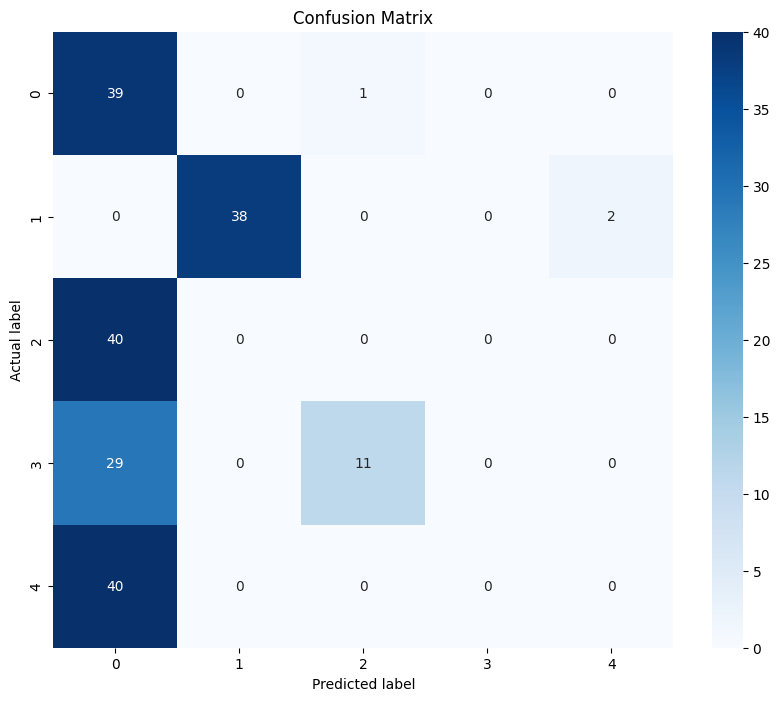

In [279]:
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_with_f1_score_and_cm(loader, model, criterion, device):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            outputs = model.fault_classfier(model.forward(data))
            loss = criterion(outputs, target)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = 100 * sum(np.array(all_predictions) == np.array(all_targets)) / len(all_targets)
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    cm = confusion_matrix(all_targets, all_predictions)
    return avg_loss, accuracy, f1, cm

# 테스트 데이터셋에 대한 모델 평가
test_loss, test_accuracy, test_f1_score, test_cm = evaluate_with_f1_score_and_cm(test_loader, model, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test F1-Score: {test_f1_score:.2f}')

# 혼동 행렬 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()
